In [331]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn.metrics as sk_metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import tempfile
import statsmodels.api as sm
import os
from tensorflow import keras
import statsmodels.formula.api as smf

from tensorflow.keras import layers
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
import pymssql
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from tqdm import tqdm
import numpy as np
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from mpl_toolkits import mplot3d
import yaml
from scipy.stats import pearsonr
import decimal
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

random_state = 2023

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

server_info = config["server"]

print(config)

2.9.0
{'server': {'name': 'localhost', 'user': 'sa', 'password': 'Passw0rd!', 'database': 'Loans_2023_01_27'}, 'tables': [{'name': 'dbo.UnderwritingData', 'primary': 'VIN', 'secondary': 'CreaditScore', 'null_secondary': 0}, {'name': 'dbo.RawAlgorithmData', 'primary': 'Vin6', 'secondary': 'Score', 'null_secondary': 0}], 'predictions': {'target': 'ProcStatsCd', 'replace': {'CL': 1, 'CO': 0}, 'doSpecial': True, 'special': 'DelqPct'}, 'ignore': ['Class_', 'AccountShort', 'CustomerNumber', 'CurBalAmt', 'Customer', 'AdminStatus', 'NumberPmnt', 'NumberPmnt', 'ResultCD', 'ChargeOffDt', 'PercentageOfPaymentsMade', 'DelqCalcAlert', 'RecyCalcAlert', 'ApplicationNumber', 'CurrentPaymentsMade', 'Name'], 'outliers': {'ignore': ['Status', 'DelqPct', 'CreaditScore', 'HomeOwner', 'Reposessions', 'Chageoff', 'APR']}}


In [408]:
class DatabaseLoader:
    def __init__(self, _server_info):
        _conn = pymssql.connect(server=server_info['name'], user=server_info['user'], password=server_info['password'], database=server_info['database'])

        self._cursor = _conn.cursor()
        self._empty = True
        self.df = None
        self._global_primary = None
        self._global_secondary = None
        self._global_primary_type = None
        self._global_secondary_type = None
        self._target = None
        self._special_target = None

    def get_column_index(self, _column_name):
        for index, col in enumerate(self._cursor.description):
            if col[0] == _column_name:
                return index

    def replace_col_name(self, _cur_headers, _old, _new):
        for idx, header in enumerate(_cur_headers):
            if header==_old:
                _cur_headers[idx] = _new

    def load_table(self, _table_info, ignore=None):
        if ignore is None:
            ignore = []
        self._cursor.execute("SELECT * FROM {table}".format(table=_table_info['name']))

        _headers = []
        _rows = []

        for entity in self._cursor.description:
            _headers.append(entity[0])

        _primary_index = self.get_column_index(_table_info['primary'])
        _secondary_index = self.get_column_index(_table_info['secondary'])

        _res = self._cursor.fetchone()
        while _res:
            _row = [element for element in _res]
            if _row[_primary_index] is not None and _row[_primary_index].strip() != "n/a" and _row[_secondary_index] != _table_info['null_secondary']:
                # Strips trailing whitespace from strings
                for idx, item in enumerate(_row):
                    if isinstance(item, str):
                        _row[idx] = item.strip()

                    if isinstance(item, decimal.Decimal):
                        _row[idx] = float(item)

                _rows.append(_row)
            _res = self._cursor.fetchone()

        if self._empty:
            self._empty = False
            self.df = pd.DataFrame(_rows, columns=_headers)
            self._global_primary = _table_info['primary']
            self._global_secondary = _table_info['secondary']
            self._global_primary_type = type(self.df[self._global_primary].iloc[0])
            self._global_secondary_type = type(self.df[self._global_secondary].iloc[0])
        else:
            # Replace the primary and secondary key column names with the global primary and secondary key names
            self.replace_col_name(_headers, _table_info['primary'], self._global_primary)
            self.replace_col_name(_headers, _table_info['secondary'], self._global_secondary)

            temp_df = pd.DataFrame(_rows, columns = _headers)
            # Cast the primary and secondary keys to global type
            temp_df[self._global_primary] = temp_df[self._global_primary].astype(self._global_primary_type)
            temp_df[self._global_secondary] = temp_df[self._global_secondary].astype(self._global_secondary_type)

            self.df = pd.merge(temp_df, self.df, how = 'inner', on=['VIN', 'CreaditScore'])

        # Remove any columns to ignore
        self.df = self.df.drop(labels = ignore, axis=1, errors='ignore')

    def move_col_to_end(self, col):
        cols = list(self.df.columns)
        cols.remove(col)
        cols.append(col)
        self.df = self.df[cols]

    def prune_for_target(self, _prediction_info):
        self._target = _prediction_info['target']
        _replace_guide = _prediction_info['replace']

        self.df = self.df[self.df[self._target].isin(list(_replace_guide.keys()))]
        for key, value in _replace_guide.items():
            self.df[self._target].replace(to_replace=key, value=value, inplace=True)

        # Move the target to the end of the dataframe
        cols = list(self.df.columns)
        cols.remove(self._target)
        cols.append(self._target)
        self.df = self.df[cols]

        if _prediction_info['doSpecial']:
            if _prediction_info['special'] == 'DelqPct':
                self.df = self.df[self.df['OpeningBalance']!=0]
                self.df['DelqPct'] = self.df.apply(lambda row : (100*row['Delq'])/row['OpeningBalance'],axis=1)

                # Remove the old target and Delq from the dataframe
                cols = list(self.df.columns)
                cols.remove(self._target)
                cols.remove("Delq")
                self.df = self.df[cols]
                self._target = "DelqPct"


    def remove_majority_null(self, threshold = .7):
        total = len(self.df)
        cols_to_drop = []
        percents = []
        for column in self.df.columns:
            non_null_count = 0
            for idx, item in self.df[column].items():
                if item is not None:
                    non_null_count +=1
            percent = float(non_null_count)/float(total)
            if percent < threshold:
                cols_to_drop.append(column)
                percents.append((1-percent)*100)

        self.df = self.df.drop(cols_to_drop, axis = 1)
        for idx, column in enumerate(cols_to_drop):
            print("Dropping {column} since {percent}% of entires were Null".format(column=column, percent = percents[idx]))

    def contains_null_or_is_categorical(self, series):
        if self.is_categorical(series):
            return True

        for idx, item in series.items():
            if item is None:
                return True

        return False

    def get_type_series(self, series):
        for idx, item in series.items():
            if item is not None:
                return type(item)
        return None

    def is_categorical(self, series):
        return self.get_type_series(series) == str

    def get_correlated_entities(self, threshold = 0.1, inplace= False):
        corrs = dict()
        for col in self.df.columns:
            if col == self._target or self.contains_null_or_is_categorical(self.df[col]):
                continue
            corr, _ = pearsonr(self.df[col], self.df[self._target])
            corrs[col] = abs(corr)

        corrs = {k: v for k, v in sorted(corrs.items(), key=lambda item: item[1])}

        goodCols = []

        for col, score in corrs.items():
            if score>=threshold:
                goodCols.append(col)

        if inplace:
            goodCols.append(self._target)
            self.df = self.df[goodCols]
        else:
            return self.df[goodCols]

    def remove_outliers(self, lower_thresh = 0.00, upper_thresh = 0.999, ignore=None):
        if ignore is None:
            ignore = []
        for col in self.df.columns:
            if col in ignore or col==self._target or self.is_categorical(self.df[col]):
                continue
            percentiles = self.df[col].quantile([lower_thresh, upper_thresh]).values
            self.df.loc[self.df[col]<=percentiles[0], col] = percentiles[0]
            self.df.loc[self.df[col]>=percentiles[1], col] = percentiles[1]

    def get_target_col(self):
        return self.df[self._target]

    def get_categorical_vars(self):
        cats = []
        for col in self.df.columns:
            if self.is_categorical(self.df[col]):
                cats.append(col)
        return cats

    def one_hot(self, inplace = False):
        cat_attribs = self.get_categorical_vars()
        full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)], remainder='passthrough')
        encoder = full_pipeline.fit(self.df)
        if inplace:
            self.df = encoder.transform(self.df)
        else:
            return encoder.transform(self.df)

    def one_hot_dummies(self, inplace=False):
        cat_attribs = self.get_categorical_vars()
        temp_df = self.df.copy(deep=True)
        for cat in cat_attribs:
            one_hot = pd.get_dummies(self.df[cat])
            for i in one_hot.columns:
                new_name = cat+i
                new_name = new_name.replace("[", "")
                new_name = new_name.replace("]", "")
                new_name = new_name.replace("<", "")
                one_hot.rename(columns={i:new_name}, inplace=True)
            temp_df = temp_df.drop(cat, axis=1)
            temp_df = pd.concat([temp_df, one_hot], axis=1)

        if inplace:
            self.df = temp_df
            self.move_col_to_end(self._target)
        else:
            return temp_df

In [409]:
dbl = DatabaseLoader(server_info)

dbl.load_table(config['tables'][0], ignore=config['ignore'])
dbl.load_table(config['tables'][1], ignore=config['ignore'])
dbl.prune_for_target(config['predictions'])
dbl.remove_majority_null()

corents = dbl.get_correlated_entities()
print("Most Correlated Columns")
print(corents.columns)

dbl.remove_outliers(ignore = config['outliers']['ignore'])

dbl.one_hot_dummies(True)

print(dbl.df)
# print(dbl.df)

# plt.scatter(df["CurrentPaymentsMade"], df["DelqPct"])
# plt.show()


# print(df)


Dropping Discount since 100.0% of entires were Null
Dropping CustomScore since 44.52901998097051% of entires were Null
Most Correlated Columns
Index(['Salary_y', 'NinetyDaysDelinquent', 'OpenTotalInBadStatus',
       'CreaditScore', 'CashDown', 'Term', 'OrigTerm', 'Apr', 'OpeningBalance',
       'Recy'],
      dtype='object')


/Users/nikhil/Documents/401/CODE/Scorelate/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


       CreaditScore  Salary_x    Recy  OrigTerm    Apr  OpeningBalance  \
0               676    600.00   490.0        42  20.98         8231.24   
1               532   9026.33   400.0        48  22.99        13048.40   
2               531   2800.00   165.0        48  24.99         8704.21   
3               572   2000.00    70.0        48  22.00        11913.48   
4               513   4533.00   293.0        48  22.95        11375.39   
...             ...       ...     ...       ...    ...             ...   
13140           516   7000.00    18.0        54  18.99        12423.17   
13164           580   3000.00    29.0        46  22.90        11500.00   
13167           566   3640.00    30.0        48  21.90        14700.00   
13212           512   2850.00  1287.0        48  24.90        11500.00   
13213           462   4300.00  1413.0        52  19.90        16001.94   

       Salary_y  EmploymentMonths  Term  Payment  ...  VehicleTypeTruck  \
0        1600.0                 0   

## XGBoost

In [ ]:
xgdata = dbl.df.copy(deep=True)


accs = []
for x in tqdm(range(3)):
    x_train, x_test, y_train, y_test = train_test_split(xgdata.iloc[:,:-1], xgdata.iloc[:,-1:], test_size=0.2)

    train = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)
    test = xgb.DMatrix(x_test, label=y_test, enable_categorical=True)

    param = {
        'eta': 0.01,
        'objective': 'reg:squarederror',
    }
    epochs = 500

    model = xgb.train(param, train, epochs)

    predictions = model.predict(test)

    y = []

    for z in predictions:
        y.append(np.argmax(z))

    acc = round(metrics.mean_squared_error(y_test, y, squared=False), 3)
    # model.save_model('Models/Delq/XGBoost_{}%_Scorelate.json'.format(acc))

    print("Acc: ", end='')
    print(acc)

    accs.append(acc)

    pred = model.predict(xgb.DMatrix(x_test))
    print("Preds")
    print(pred[:10])
    print("Test")
    print(y_test[:10])

print(sum(accs)/len(accs))

  0%|          | 0/3 [00:00<?, ?it/s]

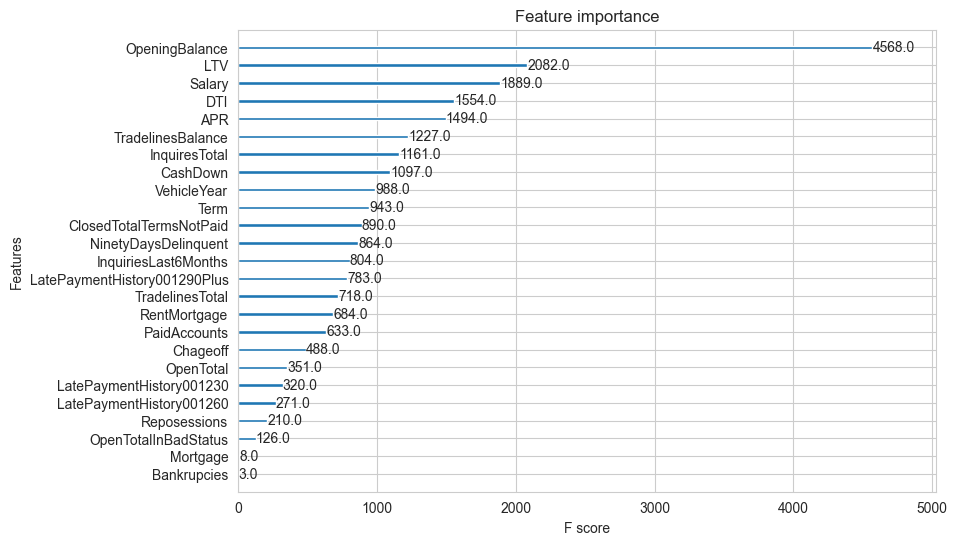

In [180]:
xgb_ml = xgb.Booster()

xgb_ml.load_model('Models/Delq/XGBoost_6.765%_Scorelate.json')
# x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.2)
# print(xgb_ml.predict(xgb.DMatrix(x_test[:5])))
# print(y_test[:5])

# plot feature importance
plot_importance(xgb_ml)
plt.show()

In [365]:
res = xgb_ml.predict(xgb.DMatrix(x_test))
preds = []
actual = []
for pred in res:
    if(pred<3.5):
        preds.append("Paid")
    else:
        preds.append("CO")

for result in y_test["DelqPct"]:
    if result == 0.0:
        actual.append("Paid")
    else:
        actual.append("CO")

paidandpredpaid = 0
paidandpredco = 0
coandpredpaid = 0
coandpredco = 0

avgPaid = []
avgCO = []

for i in range(len(preds)):
    if preds[i]=="Paid" and actual[i]=="Paid":
        paidandpredpaid+=1
    elif preds[i]=="CO" and actual[i]=="Paid":
        paidandpredco+=1
    elif preds[i]=="Paid" and actual[i]=="CO":
        coandpredpaid+=1
    elif preds[i]=="CO" and actual[i]=="CO":
        coandpredco+=1
    if(actual[i]=="Paid"):
        avgPaid.append(res[i])
    else:
        avgCO.append(res[i])

print("Paid and Pred Paid: ", paidandpredpaid)
print("Paid and Pred CO: ", paidandpredco)
print("CO and Pred Paid: ", coandpredpaid)
print("CO and Pred CO: ", coandpredco)

print("Avg Paid: ", sum(avgPaid)/len(avgPaid))
print("Avg CO: ", sum(avgCO)/len(avgCO))

NameError: name 'xgb_ml' is not defined